In [1]:
#importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
from sklearn.impute import SimpleImputer

In [2]:
#importing the incident dataset for analysis
df=pd.read_csv('./incident_event_log.csv')
df.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,u_priority_confirmation,notify,problem_id,rfc,vendor,caused_by,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,0,0,0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,0,0,2,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,0,0,3,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,0,0,4,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,0,0,0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,False,Do Not Notify,?,?,?,?,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [3]:
#Analysing the shape of the dataframe
df.shape

(141712, 36)

In [4]:
#Calculating NA's in each column
df.isnull().sum(axis=0) 

number                     0
incident_state             0
active                     0
reassignment_count         0
reopen_count               0
sys_mod_count              0
made_sla                   0
caller_id                  0
opened_by                  0
opened_at                  0
sys_created_by             0
sys_created_at             0
sys_updated_by             0
sys_updated_at             0
contact_type               0
location                   0
category                   0
subcategory                0
u_symptom                  0
cmdb_ci                    0
impact                     0
urgency                    0
priority                   0
assignment_group           0
assigned_to                0
knowledge                  0
u_priority_confirmation    0
notify                     0
problem_id                 0
rfc                        0
vendor                     0
caused_by                  0
closed_code                0
resolved_by                0
resolved_at   

In [5]:
#Checking for the datatypes present in the dataframe
df.dtypes

number                     object
incident_state             object
active                       bool
reassignment_count          int64
reopen_count                int64
sys_mod_count               int64
made_sla                     bool
caller_id                  object
opened_by                  object
opened_at                  object
sys_created_by             object
sys_created_at             object
sys_updated_by             object
sys_updated_at             object
contact_type               object
location                   object
category                   object
subcategory                object
u_symptom                  object
cmdb_ci                    object
impact                     object
urgency                    object
priority                   object
assignment_group           object
assigned_to                object
knowledge                    bool
u_priority_confirmation      bool
notify                     object
problem_id                 object
rfc           

In [6]:
#Estimating the range of values in the dataset
df.describe()

,reassignment_count,reopen_count,sys_mod_count
count,141712.000000,141712.000000,141712.000000
mean,1.104197,0.021918,5.080946
std,1.734673,0.207302,7.680652
min,0.000000,0.000000,0.000000
25%,0.000000,0.000000,1.000000
50%,1.000000,0.000000,3.000000
75%,1.000000,0.000000,6.000000
max,27.000000,8.000000,129.000000


In [7]:
#df.drop(['cmdb_ci', 'problem_id', 'rfc', 'vendor','caused_by','caller_id','opened_by','sys_created_by','sys_updated_by','location','resolved_by','notify','assigned_to','assignment_group'],axis = 1,inplace=True)

In [8]:
 #Replacing ? in the dataframe
df.replace('?', np.NaN, inplace = True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 141712 entries, 0 to 141711
Data columns (total 36 columns):
 #   Column                   Non-Null Count   Dtype 
---  ------                   --------------   ----- 
 0   number                   141712 non-null  object
 1   incident_state           141712 non-null  object
 2   active                   141712 non-null  bool  
 3   reassignment_count       141712 non-null  int64 
 4   reopen_count             141712 non-null  int64 
 5   sys_mod_count            141712 non-null  int64 
 6   made_sla                 141712 non-null  bool  
 7   caller_id                141683 non-null  object
 8   opened_by                136877 non-null  object
 9   opened_at                141712 non-null  object
 10  sys_created_by           88636 non-null   object
 11  sys_created_at           88636 non-null   object
 12  sys_updated_by           141712 non-null  object
 13  sys_updated_at           141712 non-null  object
 14  contact_type        

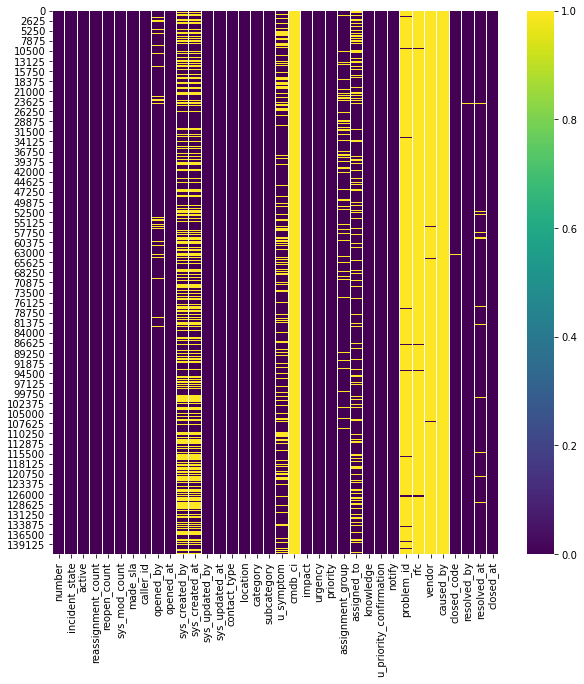

In [9]:
#Generating a heatmap to explore the columns which have most NA values
fig, ax = plt.subplots(figsize=(10,10))  
sns.heatmap(df.isnull(), cmap='viridis',ax=ax) 

In [10]:
#Removing the columns which had NA values the most
df_processed = df.drop(['cmdb_ci', 'problem_id', 'rfc', 'vendor', 'caused_by'],axis=1) 

In [11]:
#remove outliers
df_processed = df_processed[df_processed['incident_state'] != '-100' ]

In [12]:
reass_count_labels = [1,2,3,4,5]
df_processed['reassignment_count'] = pd.cut(df_processed['reassignment_count'],bins = 5, labels = reass_count_labels)

In [13]:
#Replacing with mean for numerical columns
df_imputer=SimpleImputer(missing_values=np.NaN, strategy='mean', verbose=0)
df_imputer=df_imputer.fit(df_processed.loc[:,['reopen_count', 'sys_mod_count']])# columns with missing values
df_processed.loc[:,['reopen_count', 'sys_mod_count']]=df_imputer.transform(df_processed.loc[:,['reopen_count', 'sys_mod_count']])

In [14]:
# replace subtypes of Awaiting incident state into main type of Awaiting
df_processed['incident_state'].replace(['Awaiting User Info','Awaiting Problem','Awaiting Vendor','Awaiting Evidence'],'Awaiting',inplace = True)

In [15]:
df_processed['incident_state'].unique()

array(['New', 'Resolved', 'Closed', 'Active', 'Awaiting'], dtype=object)

In [16]:
#Replacing with mode for categorical columns
for column in ['caller_id', 'opened_by', 'sys_created_by','sys_created_at','location','category','subcategory','u_symptom','assignment_group','assigned_to','closed_code','resolved_by','resolved_at']:
    df_processed[column].fillna(df_processed[column].mode()[0], inplace=True) 

In [17]:
df_processed.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,New,True,1,0.0,0.0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,Resolved,True,1,0.0,2.0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,Resolved,True,1,0.0,3.0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,Closed,False,1,0.0,4.0,True,Caller 2403,Opened by 8,29/2/2016 01:16,...,3 - Moderate,Group 56,Resolver 17,True,False,Do Not Notify,code 5,Resolved by 149,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,New,True,1,0.0,0.0,True,Caller 2403,Opened by 397,29/2/2016 04:40,...,3 - Moderate,Group 70,Resolver 89,True,False,Do Not Notify,code 5,Resolved by 81,1/3/2016 09:52,6/3/2016 10:00


In [18]:
df_processed.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group',
       'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

# Exploratory Data Analysis

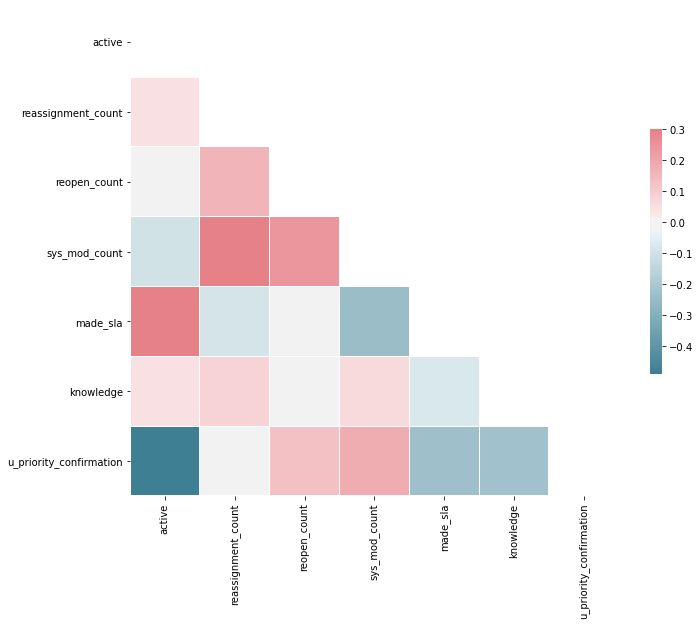

In [19]:
#Compute the correlation matrix
corr = df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=np.bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

## We can have the distribution of different state of incidents in the data

In [20]:
## Let's see the distribution of different state of incidents in the data

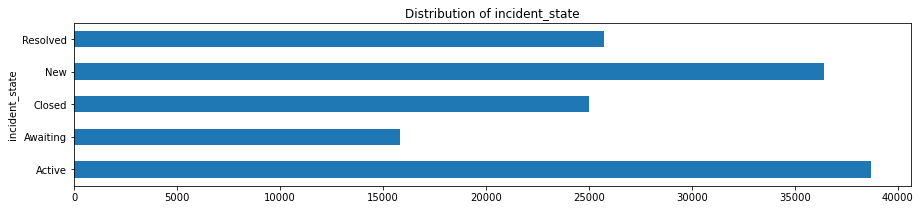

Active      38716
New         36407
Resolved    25751
Closed      24985
Awaiting    15848
Name: incident_state, dtype: int64

In [21]:
df_processed.groupby('incident_state') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of incident_state',
          figsize=(15, 3))
plt.show()
df_processed['incident_state'].value_counts()

In [22]:
### Because our main priority is to predict high priority tickets, it's important for us to select only the 'closed' incident states to help us with unique incidents

In [23]:
### We can have an analysis with how many closed incidents are getting reopened

In [24]:
df_closed = df_processed["incident_state"] == "Closed"
df_closed = df_processed[df_closed]

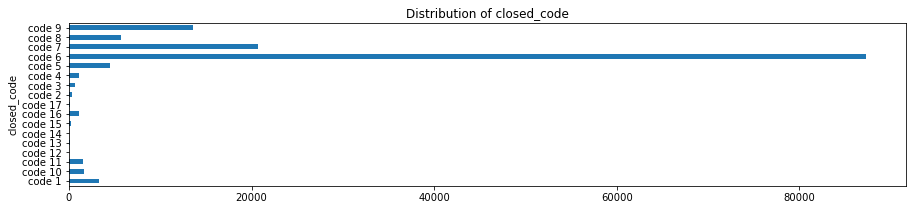

code 6     87297
code 7     20728
code 9     13562
code 8      5646
code 5      4469
code 1      3265
code 10     1678
code 11     1493
code 4      1139
code 16     1091
code 3       608
code 2       349
code 15      183
code 17      115
code 13       59
code 12       13
code 14       12
Name: closed_code, dtype: int64

In [25]:
df_processed.groupby('closed_code') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of closed_code',
          figsize=(15, 3))
plt.show()
df_processed['closed_code'].value_counts()

#### As we can see Code 6,7,8,9 are the major ones with which the incidents are getting closed. Let us check if that happens for the ones which are getting reopened or it is different?

In [26]:
df_closed_reopened = df_closed["reopen_count"] > 0
df_closed_reopened = df_closed[df_closed_reopened]

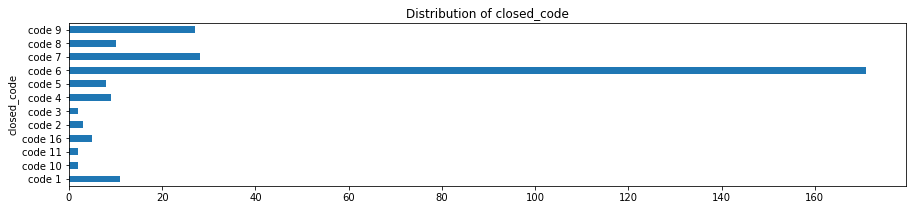

code 6     171
code 7      28
code 9      27
code 1      11
code 8      10
code 4       9
code 5       8
code 16      5
code 2       3
code 11      2
code 3       2
code 10      2
Name: closed_code, dtype: int64

In [27]:
df_closed_reopened.groupby('closed_code') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of closed_code',
          figsize=(15, 3))
plt.show()
df_closed_reopened['closed_code'].value_counts()

#### We can see the close code are similar for reopened tickets but we see that there are other close codes too which are ending as reason to close the reopened tickets. Let us now see if these reopened has any pattern with SLA.

In [59]:
df_closed['made_sla'].value_counts()

True     15831
False     9154
Name: made_sla, dtype: int64

In [29]:
df_closed_reopened['made_sla'].value_counts()

False    210
True      68
Name: made_sla, dtype: int64

### Now as we see that reopened incidents are missing SLAs so now let us exmaine distribution of incidents which are missing SLAs

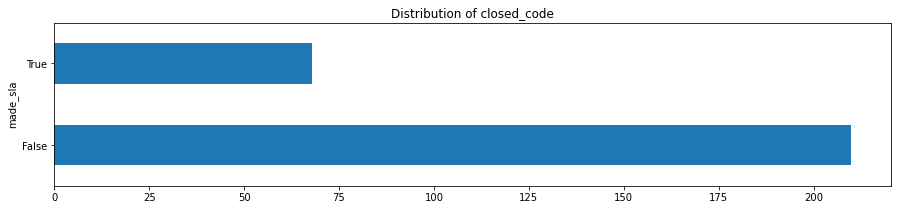

True     15831
False     9154
Name: made_sla, dtype: int64

In [30]:
df_closed_reopened.groupby('made_sla') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of closed_code',
          figsize=(15, 3))
plt.show()
df_closed['made_sla'].value_counts()

In [31]:
df_closed_sla = df_closed["made_sla"] == 1
df_closed_sla = df_closed[df_closed_sla]

In [32]:
pd.crosstab(df_closed['made_sla'],df_closed['priority'])

priority,1 - Critical,2 - High,3 - Moderate,4 - Low
made_sla,,,,
False,265,406,8358,125
True,6,2,15171,652


#### There is very clear pattern that if SLAs mostly get missed for critical and high priortiy incidents whereas SLAs are met for Moderate and Low priortiy incidents.

### Now let us look how closed incidents are impacted performs when it comes to priority

In [33]:
df_closed['impact'].value_counts()

2 - Medium    23809
3 - Low         754
1 - High        422
Name: impact, dtype: int64

In [34]:
df_closed_reopened['impact'].value_counts()

2 - Medium    273
1 - High        3
3 - Low         2
Name: impact, dtype: int64

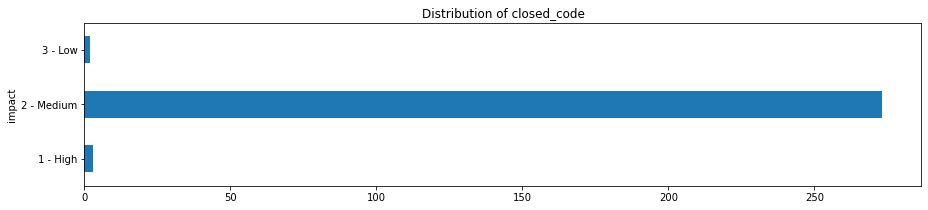

2 - Medium    23809
3 - Low         754
1 - High        422
Name: impact, dtype: int64

In [35]:
df_closed_reopened.groupby('impact') \
    .count()['number'] \
    .plot(kind='barh',
          title='Distribution of closed_code',
          figsize=(15, 3))
plt.show()
df_closed['impact'].value_counts()

In [36]:
pd.crosstab(df_closed['impact'],df_closed['priority'])

priority,1 - Critical,2 - High,3 - Moderate,4 - Low
impact,,,,
1 - High,271,151,0,0
2 - Medium,0,257,23525,27
3 - Low,0,0,4,750


In [37]:
# Applying labelencoder to transform categorical value to numerical value
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_processed[['incident_state', 'active', 'reassignment_count','reopen_count', 'sys_mod_count', 'made_sla', 'caller_id',        'opened_by','sys_created_by','sys_updated_by','contact_type', 'location', 'category', 'subcategory','u_symptom', 'impact',            'urgency', 'priority', 'assignment_group','assigned_to', 'knowledge', 'u_priority_confirmation', 'notify','closed_code',              'resolved_by']] = df_processed[['incident_state', 'active', 'reassignment_count','reopen_count', 'sys_mod_count', 'made_sla', 'caller_id',        'opened_by','sys_created_by','sys_updated_by','contact_type', 'location', 'category', 'subcategory','u_symptom', 'impact',            'urgency', 'priority', 'assignment_group','assigned_to', 'knowledge', 'u_priority_confirmation', 'notify','closed_code',              'resolved_by']].apply(le.fit_transform) 
df_processed['number'] = df_processed['number']

In [38]:
df_processed.head(8)

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,priority,assignment_group,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at
0,INC0000045,3,1,0,0,0,1,1462,200,29/2/2016 01:16,...,2,47,73,1,0,0,12,51,29/2/2016 11:29,5/3/2016 12:00
1,INC0000045,4,1,0,0,2,1,1462,200,29/2/2016 01:16,...,2,47,73,1,0,0,12,51,29/2/2016 11:29,5/3/2016 12:00
2,INC0000045,4,1,0,0,3,1,1462,200,29/2/2016 01:16,...,2,47,73,1,0,0,12,51,29/2/2016 11:29,5/3/2016 12:00
3,INC0000045,2,0,0,0,4,1,1462,200,29/2/2016 01:16,...,2,47,73,1,0,0,12,51,29/2/2016 11:29,5/3/2016 12:00
4,INC0000047,3,1,0,0,0,1,1462,120,29/2/2016 04:40,...,2,63,223,1,0,0,12,196,1/3/2016 09:52,6/3/2016 10:00
5,INC0000047,0,1,0,0,1,1,1462,120,29/2/2016 04:40,...,2,15,167,1,0,0,12,196,1/3/2016 09:52,6/3/2016 10:00
6,INC0000047,0,1,0,0,2,1,1462,120,29/2/2016 04:40,...,2,15,167,1,0,0,12,196,1/3/2016 09:52,6/3/2016 10:00
7,INC0000047,0,1,0,0,3,1,1462,120,29/2/2016 04:40,...,2,15,167,1,0,0,12,196,1/3/2016 09:52,6/3/2016 10:00


In [39]:
df_processed.columns

Index(['number', 'incident_state', 'active', 'reassignment_count',
       'reopen_count', 'sys_mod_count', 'made_sla', 'caller_id', 'opened_by',
       'opened_at', 'sys_created_by', 'sys_created_at', 'sys_updated_by',
       'sys_updated_at', 'contact_type', 'location', 'category', 'subcategory',
       'u_symptom', 'impact', 'urgency', 'priority', 'assignment_group',
       'assigned_to', 'knowledge', 'u_priority_confirmation', 'notify',
       'closed_code', 'resolved_by', 'resolved_at', 'closed_at'],
      dtype='object')

In [40]:
df_processed['reassignment_count'].unique()

array([0, 1, 2, 3, 4], dtype=int64)

In [41]:
df_processed[['priority','incident_state']].groupby('incident_state').agg(['count'])

,priority
,count
incident_state,
0,38716
1,15848
2,24985
3,36407
4,25751


In [42]:
# df['active'] = df['active'].apply(lambda x : 1 if x == 'True' else 0)
# df['made_sla'] = df['made_sla'].apply(lambda x : 1 if x == 'True' else 0)
# df['knowledge'] = df['knowledge'].apply(lambda x : 1 if x == 'True' else 0)
# df['u_priority_confirmation'] = df['u_priority_confirmation'].apply(lambda x : 1 if x == 'True' else 0)
# df['priority'] = df['priority'].apply(lambda x : 1 if '1' in x else 2 if '2' in x else 3 if '3' in x else 4)
# df['impact'] = df['impact'].apply(lambda x : 1 if '1' in x else 2 if '2' in x else 3 if '3' in x else 4)
# df['urgency'] = df['urgency'].apply(lambda x : 1 if '1' in x else 2 if '2' in x else 3 if '3' in x else 4)
# reass_count_labels = [1,2,3,4,5]
# df['reassignment_count'] = pd.cut(df['reassignment_count'],bins = 5, labels = reass_count_labels)
# df = pd.get_dummies(df,columns = ['incident_state'])

In [43]:
#Convert date time string values into pandas datetime values
df_processed['closed_at'] = pd.to_datetime(df_processed['closed_at'])
df_processed['opened_at'] = pd.to_datetime(df_processed['opened_at'])
df_processed['resolved_at'] = pd.to_datetime(df_processed['resolved_at'])
df_processed['sys_updated_at'] = pd.to_datetime(df_processed['sys_updated_at'])


In [44]:
#calculate features like lifetime = time the incident was active, action_at = time taken when first action was undertaken
df_processed['lifetime'] = df_processed['closed_at'] - df_processed['opened_at']
df_processed['action_at'] = df_processed['sys_updated_at'] - df_processed['opened_at']

In [45]:
#extract only the day values from datetime value for features
df_processed['lifetime'] = df_processed['lifetime'].dt.days
df_processed['action_at'] = df_processed['action_at'].dt.days

In [46]:
#check number of records having close time before open time (which is wrong : It is because the the record opentime was updated by the user. Hence we extract the original open time by sorting cases with similar case number in ascending order and taking the opentime from the record with earliest system updated time)
df_processed['number'][df_processed['lifetime'] < 0], df_processed['opened_at'][df_processed['lifetime'] < 0]

(489       INC0000174
 490       INC0000174
 491       INC0000174
 492       INC0000174
 493       INC0000174
              ...    
 141665    INC0118952
 141666    INC0118952
 141667    INC0118999
 141668    INC0118999
 141669    INC0118999
 Name: number, Length: 50482, dtype: object,
 489      2016-02-29 10:39:00
 490      2016-02-29 10:39:00
 491      2016-02-29 10:39:00
 492      2016-02-29 10:39:00
 493      2016-02-29 10:39:00
                  ...        
 141665   2017-10-02 14:48:00
 141666   2017-10-02 14:48:00
 141667   2017-10-02 15:55:00
 141668   2017-10-02 15:55:00
 141669   2017-10-02 15:55:00
 Name: opened_at, Length: 50482, dtype: datetime64[ns])

In [47]:
def update_same_case_records(df):
    df.reset_index()
    unique_case_ids = df['number'].unique()
    if len(unique_case_ids) > 0:
        for case_id in tqdm(unique_case_ids):
            #indicidual case id reccords
            df_case = df[df['number'] == case_id]
            #sort the column by system updated at
            sorted_df_case = df_case.sort_values('sys_updated_at')
            #sorted_df_case.reset_index(inplace=True)
            initial_record = sorted_df_case.iloc[[0]]
            latest_record = sorted_df_case.iloc[[sorted_df_case.shape[0]-1]]
            lifetime = latest_record['closed_at'] - latest_record['opened_at']
            lifetime = lifetime.dt.days.values[0]
            if  lifetime <= 0: latest_record['opened_at'] = initial_record['sys_updated_at'].values
            df = df[df['number'] != case_id]
            if df['number'].isnull().values.any():
                df = pd.concat([df,latest_record.to_frame()])
            else: df = pd.concat([df,latest_record])
    return df


In [48]:
df_same_case = df_processed[df_processed['lifetime'] < 0]
df_unique_case = df_processed[df_processed['lifetime'] > 0]

In [49]:
df_same_case = update_same_case_records(df_same_case)

  0%|                                                                                         | 0/8614 [00:00<?, ?it/s]<ipython-input-47-3d9a19f9dc88>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if  lifetime <= 0: latest_record['opened_at'] = initial_record['sys_updated_at'].values
100%|██████████████████████████████████████████████████████████████████████████████| 8614/8614 [02:59<00:00, 48.11it/s]


In [61]:
#merge unique cases and the newly created df having single record for every case number
df_new = pd.concat([df_unique_case,df_same_case])

In [62]:
# create features lifetime and action_at
df_new['lifetime'] = df_new['closed_at'] - df_new['opened_at']
df_new['action_at'] = df_new['sys_updated_at'] - df_new['opened_at']

#store only days values as features
df_new['lifetime'] = df_new['lifetime'].dt.days
df_new['action_at'] = df_new['action_at'].dt.days

#scale lifetime and action_at features
features = ['lifetime','action_at']
df_new[features] = scaler.fit_transform(df_new[features])

In [63]:
df_new.head()

,number,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,caller_id,opened_by,opened_at,...,assigned_to,knowledge,u_priority_confirmation,notify,closed_code,resolved_by,resolved_at,closed_at,lifetime,action_at
0,INC0000045,3,1,0,0,0,1,1462,200,2016-02-29 01:16:00,...,73,1,0,0,12,51,2016-02-29 11:29:00,2016-05-03 12:00:00,0.106136,0.335171
1,INC0000045,4,1,0,0,2,1,1462,200,2016-02-29 01:16:00,...,73,1,0,0,12,51,2016-02-29 11:29:00,2016-05-03 12:00:00,0.106136,0.335171
2,INC0000045,4,1,0,0,3,1,1462,200,2016-02-29 01:16:00,...,73,1,0,0,12,51,2016-02-29 11:29:00,2016-05-03 12:00:00,0.106136,0.335171
3,INC0000045,2,0,0,0,4,1,1462,200,2016-02-29 01:16:00,...,73,1,0,0,12,51,2016-02-29 11:29:00,2016-05-03 12:00:00,0.106136,0.405733
4,INC0000047,3,1,0,0,0,1,1462,120,2016-02-29 04:40:00,...,223,1,0,0,12,196,2016-01-03 09:52:00,2016-06-03 10:00:00,0.157546,0.335171


In [64]:
#check if there are records with negative lifetime
df_new['number'][df_new['lifetime'] < 0], df_new['opened_at'][df_new['lifetime'] < 0]

(Series([], Name: number, dtype: object),
 Series([], Name: opened_at, dtype: datetime64[ns]))

In [65]:
# store case numbers for analytical purpose
ids = df_new['number']
df_new.drop(['number'],inplace = True, axis = 1)

In [66]:
df_new.columns

Index(['incident_state', 'active', 'reassignment_count', 'reopen_count',
       'sys_mod_count', 'made_sla', 'caller_id', 'opened_by', 'opened_at',
       'sys_created_by', 'sys_created_at', 'sys_updated_by', 'sys_updated_at',
       'contact_type', 'location', 'category', 'subcategory', 'u_symptom',
       'impact', 'urgency', 'priority', 'assignment_group', 'assigned_to',
       'knowledge', 'u_priority_confirmation', 'notify', 'closed_code',
       'resolved_by', 'resolved_at', 'closed_at', 'lifetime', 'action_at'],
      dtype='object')

In [67]:
# drop irrelevant features
df_new.drop(['closed_at','opened_at','sys_updated_at','sys_created_at','resolved_at','closed_code','category','subcategory','u_symptom','contact_type','caller_id','opened_by','sys_created_by','sys_updated_by','assigned_to','resolved_by','location','assignment_group'],axis = 1,inplace=True)

In [68]:
# reset index values and drop index column for the model input
df_new.reset_index(inplace= True)
df_new.drop(['index'],axis = 1,inplace=True)

In [69]:
df_new.head()

,incident_state,active,reassignment_count,reopen_count,sys_mod_count,made_sla,impact,urgency,priority,knowledge,u_priority_confirmation,notify,lifetime,action_at
0,3,1,0,0,0,1,1,1,2,1,0,0,0.106136,0.335171
1,4,1,0,0,2,1,1,1,2,1,0,0,0.106136,0.335171
2,4,1,0,0,3,1,1,1,2,1,0,0,0.106136,0.335171
3,2,0,0,0,4,1,1,1,2,1,0,0,0.106136,0.405733
4,3,1,0,0,0,1,1,1,2,1,0,0,0.157546,0.335171


In [71]:
df_new.to_csv('./reopened.csv')